In [1]:
import trimesh

In [2]:
from meshplot import plot

In [3]:
mesh = trimesh.load_mesh('./model_manifold.obj')

In [4]:
plot(mesh.vertices)

/home/thor/anaconda3/envs/iglenv/lib/python3.6/site-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "float32" does not match required type "float64". A coerced copy has been created.
  np.dtype(self.dtype).name))


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(1.5497207…

In [5]:
mesh.vertices.shape

(32900, 3)

In [6]:
import igl

In [7]:
_,v_,f_,_,_ = igl.decimate(mesh.vertices,mesh.faces, 1500)
print(v_.shape)
# v_[:,0] = (v_[:,0] - v_[:,0].min()) / (v_[:,0].max() - v_[:,0].min())
# v_[:,1] = (v_[:,1] - v_[:,1].min()) / (v_[:,1].max() - v_[:,1].min())
# v_[:,2] = (v_[:,2] - v_[:,2].min()) / (v_[:,2].max() - v_[:,2].min())

(728, 3)


In [8]:
mesh = trimesh.Trimesh(v_,f_)

In [9]:
plot(mesh.vertices)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0028013…

In [10]:
import numpy as np

In [11]:
normal = np.random.randn(3)
normal /= np.linalg.norm(normal)
point = np.random.randn(3)

In [44]:
!pip install triangle

In [12]:
bbox_mesh = trimesh.Trimesh()

In [13]:
def generate_box_mesh(v):
    v1 = 0
    v2 = 1
    v3 = 2
    v4 = 3
    v5 = 4
    v6 = 5
    v7 = 6
    v8 = 7

    bbox_tri = np.array([[v1, v2, v5], [v2, v5, v6], [v2, v3, v6], \
                    [v6, v7, v3], [v3, v7, v8], [v8, v4, v3], [v4, v8, v5],\
                   [v5, v4, v1], [v5, v6, v8], [v8, v6, v7], [v2, v4, v1], [v2, v4, v3]
                   ])

    zmin = v[:,-1].min() + 0.1 * v[:,-1].min()
    zmax = v[:,-1].max() + 0.1 * v[:,-1].max()
    ymin = v[:,-2].min() + 0.1 * v[:,-2].min() 
    ymax = v[:, -2].max() + 0.1 * v[:, -2].max() 
    xmin = v[:, -3].min() + 0.1 * v[:, -3].min() 
    xmax = v[:, -3].max() + v[:, -3].max()

    bbox_verts = np.array([[xmin, ymin, zmax],[xmax,ymin,zmax],[xmax, ymin, zmin],\
                  [xmin, ymin, zmin], [xmin, ymax, zmax], [xmax, ymax, zmax],\
                  [xmax, ymax, zmin], [xmin, ymax, zmin]])
    
    return bbox_verts, bbox_tri

In [14]:
bbox_verts, bbox_tri = generate_box_mesh(mesh.vertices)

bbox_mesh = trimesh.Trimesh(bbox_verts, bbox_tri)

In [15]:
from meshplot import plot

In [16]:

normal = np.random.randn(3)
normal /= np.linalg.norm(normal)
point = np.random.randn(3)

point = np.array([-0.54905429,  0.14446151, -0.16177154])
normal = np.array([-0.19714132, -0.87347182,  0.44517669])
polyline, triangles_edge = trimesh.intersections.mesh_plane(mesh, 
                                                           plane_origin= point, 
                                                           plane_normal= normal, 
                                                           return_faces=True)

print(polyline.shape)
m = plot(mesh.vertices)
# m.add_mesh(bbox_verts, bbox_tri)
m.add_points(polyline.reshape(-1,3), c='blue')

(48, 2, 3)


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0028013…

1

In [17]:
point,normal


(array([-0.54905429,  0.14446151, -0.16177154]),
 array([-0.19714132, -0.87347182,  0.44517669]))

In [18]:
bbox_mesh = trimesh.Trimesh()
bbox_mesh.vertices = bbox_verts
bbox_mesh.faces  = bbox_tri

In [19]:
# def unordered_to_triangles(points):
#     triangles = [[points[0], points[1], points[2]], [points[1], points[2],points[3]]]
#     return np.array(triangles)

def unordered_to_triangles(points):
    triangles = [[points[0], points[1], points[2]], [points[0], points[1],points[3]],[points[0], points[1], points[2]], [points[1], points[2],points[3]]]
    return np.array(triangles)
def unordered_to_triangles(points):
    triangles = [[points[0], points[2], points[3]], [points[1], points[2], points[3]]]
    return np.array(triangles)

In [20]:
import random

In [83]:
def split_mesh(mesh, plane_normal=None, plane_origin=None):
    """
    Splits mesh by intersection with a plane, 
    returns closed mesh for positive and negative side of plane 
    """
#     plane_normal = (plane_normal)
#     plane_normal = plane_normal
#     plane_origin = plane_origin
    done = False
    while not done:
        if plane_normal is  None and plane_origin is  None:
            plane_normal_ = np.random.randn(3)
            plane_normal_ /= np.linalg.norm(plane_normal_)
#             plane_origin_ = np.random.randn(3)
            plane_origin_ = np.mean(mesh.vertices, 0)
#             plane_origin_ = mesh.vertices[random.randint(0, len(mesh.vertices)-1)]
        else:
            plane_normal_ = plane_normal
            plane_origin_ = plane_origin
        polyline, triangles_edge = trimesh.intersections.mesh_plane(mesh, 
                                                           plane_origin= plane_origin_, 
                                                           plane_normal= plane_normal_, 
                                                           return_faces=True)
        
#         print(polyline.shape)
        if polyline.shape[0]>0:
            print(plane_normal_, plane_origin_)
            print(polyline.shape)
            done = True
            break
        elif plane_normal is not None and plane_origin is not None and len(polyline)==0:
            print('Plane does not pass')
            print(plane_normal_, plane_origin_)
         
                                                                        
            return None, None
        
    print('found')
    plane_normal = plane_normal_
    plane_origin = plane_origin_
    
    vertices_negative = []
    vertices_positive = []
    for vertex_id, vertex in enumerate(mesh.vertices):
        # TODO: add threshold
        signed_distance = np.dot(plane_normal, np.subtract(vertex, plane_origin))
        if signed_distance < 0:
            vertices_negative.append(vertex_id)
        else:
            vertices_positive.append(vertex_id)
    
    triangles_negative = []
    triangles_positive = []
    # For each triangle check how many points on either side of the plane
    for triangle in mesh.faces:
        triangle_negative_check = [vertex_id in vertices_negative for vertex_id in triangle]
        # If all points on the negative side this triangle is not affected
        if all(triangle_negative_check):
            triangles_negative.append(np.array(mesh.vertices[triangle]))
        elif any(triangle_negative_check):
            # Get section line for this triangle on edge
            section = polyline[np.all(np.isin(mesh.faces[triangles_edge], np.array(triangle)), axis=1)][0]
            assert section.shape == (2,3)
            # If two points on negative side
            if sum(triangle_negative_check) == 2:
                vertex_1, vertex_2 = mesh.vertices[triangle[triangle_negative_check]]
                
                triangles_negative.extend(unordered_to_triangles([section[0], section[1], vertex_1, vertex_2]))
                vertex_3 = mesh.vertices[triangle[np.logical_not(triangle_negative_check)]]
                triangles_positive.append(np.vstack([section[0], section[1], vertex_3]))
            elif sum(triangle_negative_check) == 1:
                vertex_3 = mesh.vertices[triangle[triangle_negative_check]]
                triangles_negative.append(np.vstack([section[0], section[1], vertex_3]))
                vertex_1, vertex_2 = mesh.vertices[triangle[np.logical_not(triangle_negative_check)]]
#                 print(section[0], section[1], vertex_1, vertex_2)
                triangles_positive.extend(unordered_to_triangles([section[0], section[1], vertex_1, vertex_2]))
        # If all points on the positive side this triangle is not affected
        else:
            triangles_positive.append(np.array(mesh.vertices[triangle]))
            
    # Get triangulation of the split surface
    vertices_splitsurface = []
    for a, b in polyline:
        for vertex in [a,b]:
            if tuple(vertex) not in vertices_splitsurface:
                vertices_splitsurface.append(tuple(vertex))

    triangles_splitsurface = unordered_to_triangles(vertices_splitsurface)
    
    # Add triangles of split surface to both the positive and negative side
    triangles_negative.extend(triangles_splitsurface)
    triangles_positive.extend(triangles_splitsurface)
    
    print(plane_normal_, plane_origin_)
    
    return np.array(triangles_positive), np.array(triangles_negative)

### Slice mesh with heuristics

In [138]:
def split_mesh(mesh, plane_normal=None, plane_origin=None):
    """
    Splits mesh by intersection with a plane, 
    returns closed mesh for positive and negative side of plane 
    """
#     plane_normal = (plane_normal)
#     plane_normal = plane_normal
#     plane_origin = plane_origin
    done = False
    while not done:
        if plane_normal is  None and plane_origin is  None:
#             plane_normal_ = np.random.randn(3)
#             plane_normal_ /= np.linalg.norm(plane_normal_)
# #             plane_origin_ = np.random.randn(3)
            plane_origin_ = np.mean(mesh.vertices, 0)
            idx1 = random.randint(0, pos_mesh.vertices.shape[0]-1)
            idx2 = random.randint(0, pos_mesh.vertices.shape[0]-1)
            v1 = pos_mesh.vertices[idx1]
            v2 = pos_mesh.vertices[idx2]
            v_1 = (v1 - v2)/ np.linalg.norm(v1 - v2)
            idx1 = random.randint(0, pos_mesh.vertices.shape[0]-1)
            idx2 = random.randint(0, pos_mesh.vertices.shape[0]-1)
            v1 = pos_mesh.vertices[idx1]
            v2 = pos_mesh.vertices[idx2]
            v_2 = (v1- v2 )/ np.linalg.norm(v1 - v2)
            plane_normal_ = np.cross(v_1, v_2)
#             plane_origin_ = mesh.vertices[random.randint(0, len(mesh.vertices)-1)]
        else:
            plane_normal_ = plane_normal
            plane_origin_ = plane_origin
        polyline, triangles_edge = trimesh.intersections.mesh_plane(mesh, 
                                                           plane_origin= plane_origin_, 
                                                           plane_normal= plane_normal_, 
                                                           return_faces=True)
        
#         print(polyline.shape)
        if polyline.shape[0]>0:
            print(plane_normal_, plane_origin_)
            print(polyline.shape)
            done = True
            break
        elif plane_normal is not None and plane_origin is not None and len(polyline)==0:
            print('Plane does not pass')
            print(plane_normal_, plane_origin_)
         
                                                                        
            return None, None
        
    print('found')
    plane_normal = plane_normal_
    plane_origin = plane_origin_
    
    vertices_negative = []
    vertices_positive = []
    for vertex_id, vertex in enumerate(mesh.vertices):
        # TODO: add threshold
        signed_distance = np.dot(plane_normal, np.subtract(vertex, plane_origin))
        if signed_distance < 0:
            vertices_negative.append(vertex_id)
        else:
            vertices_positive.append(vertex_id)
    
    triangles_negative = []
    triangles_positive = []
    # For each triangle check how many points on either side of the plane
    for triangle in mesh.faces:
        triangle_negative_check = [vertex_id in vertices_negative for vertex_id in triangle]
        # If all points on the negative side this triangle is not affected
        if all(triangle_negative_check):
            triangles_negative.append(np.array(mesh.vertices[triangle]))
        elif any(triangle_negative_check):
            # Get section line for this triangle on edge
            section = polyline[np.all(np.isin(mesh.faces[triangles_edge], np.array(triangle)), axis=1)][0]
            assert section.shape == (2,3)
            # If two points on negative side
            if sum(triangle_negative_check) == 2:
                vertex_1, vertex_2 = mesh.vertices[triangle[triangle_negative_check]]
                
                triangles_negative.extend(unordered_to_triangles([section[0], section[1], vertex_1, vertex_2]))
                vertex_3 = mesh.vertices[triangle[np.logical_not(triangle_negative_check)]]
                triangles_positive.append(np.vstack([section[0], section[1], vertex_3]))
            elif sum(triangle_negative_check) == 1:
                vertex_3 = mesh.vertices[triangle[triangle_negative_check]]
                triangles_negative.append(np.vstack([section[0], section[1], vertex_3]))
                vertex_1, vertex_2 = mesh.vertices[triangle[np.logical_not(triangle_negative_check)]]
#                 print(section[0], section[1], vertex_1, vertex_2)
                triangles_positive.extend(unordered_to_triangles([section[0], section[1], vertex_1, vertex_2]))
        # If all points on the positive side this triangle is not affected
        else:
            triangles_positive.append(np.array(mesh.vertices[triangle]))
            
    # Get triangulation of the split surface
    vertices_splitsurface = []
    for a, b in polyline:
        for vertex in [a,b]:
            if tuple(vertex) not in vertices_splitsurface:
                vertices_splitsurface.append(tuple(vertex))

    triangles_splitsurface = unordered_to_triangles(vertices_splitsurface)
    
    # Add triangles of split surface to both the positive and negative side
    triangles_negative.extend(triangles_splitsurface)
    triangles_positive.extend(triangles_splitsurface)
    
    print(plane_normal_, plane_origin_)
    
    return np.array(triangles_positive), np.array(triangles_negative)

In [139]:
np.random.seed(123)

In [140]:
pos_mesh, neg_mesh = split_mesh(mesh, normal, point)

[ 0.7270126   0.29988907 -0.61767242] [ 0.00364515 -1.25566869 -0.55193688]
(79, 2, 3)
found
[ 0.7270126   0.29988907 -0.61767242] [ 0.00364515 -1.25566869 -0.55193688]


In [141]:
normal = np.array([ 0.7270126   , 0.29988907,  -0.61767242] )
point = np.array([ 0.00364515, -1.25566869 , -0.55193688])

In [142]:
pos_mesh = np.array(pos_mesh)
neg_mesh = np.array(neg_mesh)

In [143]:
m = plot(pos_mesh.reshape(-1, 3),c='blue')
m.add_points(neg_mesh.reshape(-1,3))

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0820813…

1

In [58]:
import math

In [59]:
# mesh_pos = trimesh.Trimesh(pos_mesh.reshape(-1,3))

In [144]:
def get_verts_faces(triangles):
    v = np.unique(triangles.reshape(-1,3),axis=0)
    faces = []
    for triangle in triangles:
        tri_indices = []
        for vertex in triangle:
            for index, v_ in enumerate(v):
                if (v_ == vertex).all():
            
                    tri_indices.append(index)
        faces.append(tri_indices)
    return v, np.array(faces)

In [145]:
v, faces = get_verts_faces(pos_mesh)


In [146]:
faces

array([[189, 157, 204],
       [157, 189, 188],
       [188, 139, 157],
       ...,
       [498, 505, 500],
       [  9,   1,   8],
       [  7,   1,   8]])

In [147]:
plot(mesh.vertices, mesh.faces)

/home/thor/anaconda3/envs/iglenv/lib/python3.6/site-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "float32" does not match required type "float64". A coerced copy has been created.
  np.dtype(self.dtype).name))
/home/thor/anaconda3/envs/iglenv/lib/python3.6/site-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "uint32" does not match required type "float64". A coerced copy has been created.
  np.dtype(self.dtype).name))


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0028013…

In [148]:
p = plot(v,faces)
p.add_lines(v[faces[:,0]], v[faces[:,1]], shading={"line_color": "red"});

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0820813…

In [149]:
patches = []


In [137]:
pos_mesh, neg_mesh = split_mesh(mesh)
verts, faces  = get_verts_faces(pos_mesh)
pos_mesh = trimesh.Trimesh(verts, faces)
# pos_mesh = trimesh.Trimesh((pos_mesh.reshape(-1,3)))
# neg_mesh = trimesh.Trimesh(neg_mesh.reshape(-1,3))
# patches.append(pos_mesh)
# patches.append(neg_mesh)
plane_origin_ = pos_mesh.vertices.mean(0)
print(plane_origin_)
idx1 = random.randint(0, pos_mesh.vertices.shape[0]-1)
idx2 = random.randint(0, pos_mesh.vertices.shape[0]-1)
v1 = pos_mesh.vertices[idx1]
v2 = pos_mesh.vertices[idx2]
v_1 = (v1 - v2)/ np.linalg.norm(v1 - v2)
idx1 = random.randint(0, pos_mesh.vertices.shape[0]-1)
idx2 = random.randint(0, pos_mesh.vertices.shape[0]-1)
v1 = pos_mesh.vertices[idx1]
v2 = pos_mesh.vertices[idx2]
v_2 = (v1- v2 )/ np.linalg.norm(v1 - v2)

cross_ = np.cross(v_1, v_2)
# plane_normal_ = np.random.randn(3)
plane_normal_ = cross_
polyline, triangles_edge = trimesh.intersections.mesh_plane(pos_mesh,\
                    plane_origin=plane_origin_,  plane_normal= cross_, return_faces=True)

print(polyline.shape)

[-0.70913009  0.65381653 -0.26392891] [-0.00260612  0.011225   -0.00451322]
(100, 2, 3)
found
[-0.70913009  0.65381653 -0.26392891] [-0.00260612  0.011225   -0.00451322]
[-0.05565712  0.01538727 -0.06430389]
(67, 2, 3)


In [92]:
pos_mesh.vertices.shape

(463, 3)

In [99]:
plot(pos_mesh.vertices)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.094889…

In [123]:
pos_mesh.faces.shape

(0, 3)

In [121]:
polyline.shape

(0, 2, 3)

In [108]:
import matplotlib.pyplot as plt

Text(0.5, 0.92, 'simple 3D scatter plot')

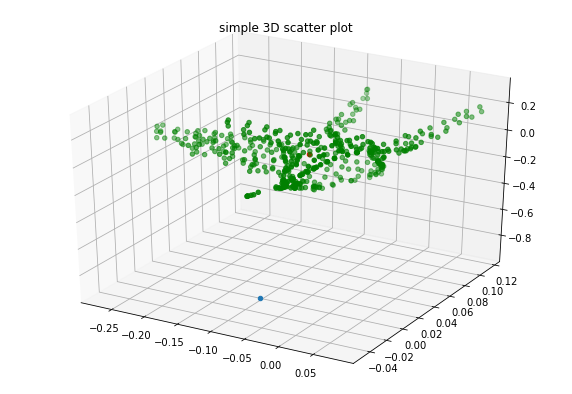

In [113]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

# Creating plot
ax.scatter3D(pos_mesh.vertices[:,0], pos_mesh.vertices[:,1], pos_mesh.vertices[:,2], color = "green")
ax.scatter3D(plane_origin_[0], plane_origin_[1], plane_origin_[2] ,color='r')
ax.scatter3D(v_1[0], v_1[1], v_1[2] )

plt.title("simple 3D scatter plot")

In [98]:
polyline.shape

(0, 2, 3)

In [151]:
p_,n = split_mesh(pos_mesh)

AttributeError: 'numpy.ndarray' object has no attribute 'vertices'

In [154]:
mesh 

<trimesh.Trimesh(vertices.shape=(728, 3), faces.shape=(1500, 3))>

In [155]:

num_patches = 10
   

patches = [mesh]

done = False
counter = 2
while not done:
    mesh = patches.pop()
    p_, n_ = split_mesh(mesh)
    print('split done')
    verts, faces  = get_verts_faces(p_)
    p_ = trimesh.Trimesh(verts, faces)
    verts, faces = get_verts_faces(n_)
    n_ = trimesh.Trimesh(verts, faces)

    patches.insert(0, p_)
    patches.insert(0, n_)

    counter+=2
    print(counter)
    if counter >= num_patches:
        break


AttributeError: 'numpy.ndarray' object has no attribute 'vertices'

In [ ]:
def linestrings_to_polygon(poly):
    polygon = []
    
    for index, pieces in enumerate(poly):
        polygon.append(pieces[0])
        polygon.append(pieces[1])
        

In [118]:
import matplotlib.pyplot as plt

In [123]:
import trimesh.intersections

def slice_mesh_plane_bidirectional(mesh, plane_normal, plane_origin):
    # Compute positive side of plane
    dots_cache = np.dot(plane_normal, (mesh.vertices - plane_origin).T)[mesh.faces]
    positive = trimesh.intersections.slice_mesh_plane(mesh,
                                                     plane_normal=plane_normal,
                                                     plane_origin=plane_origin,
                                                     )
    
    # Compute negative side of plane
    dots_cache *= -1
    negative = trimesh.intersections.slice_mesh_plane(mesh,
                                                     plane_normal=-plane_normal,
                                                     plane_origin=plane_origin,
                                                     )
    
    # Compute the cap
    cap = trimesh.intersections.mesh_plane(mesh,
                                       plane_normal=-plane_normal, 
                                       plane_origin=plane_origin, 
                                       return_faces=False, 
                                       )
    print(cap.shape)
    for piece in cap:
        plt.plot(piece)
    plt.show()
    polygon = linestrings_to_polygon(cap)
    # Triangulate the cap and add to both sides
    cap_vertices, cap_faces = trimesh.creation.triangulate_polygon(polygon)
    print(cap_vertices.shape, cap_faces.shape)
    
    # Append cap to positive mesh
    positive_vertices, n_positive_vertices = positive.vertices, len(positive.vertices)
    np.append(positive_vertices, cap_vertices, axis=0)
    positive_faces = positive.faces
    np.append(positive_faces, cap_faces+n_positive_vertices, axis=0)
    # Construct negative mesh
    positive_mesh = trimesh.base.Trimesh(vertices=positive_vertices, faces=positive_faces)
    
    # Append cap to negative mesh
    negative_vertices, n_negative_vertices = negative.vertices, len(negative.vertices)
    np.append(negative_vertices, cap_vertices, axis=0)
    negative_faces = negative.faces
    np.append(negative_faces, cap_faces+n_negative_vertices, axis=0)
    # Construct negative mesh
    negative_mesh = trimesh.base.Trimesh(vertices=negative_vertices, faces=negative_faces)

    return [positive_mesh, negative_mesh]

(141, 2, 3)


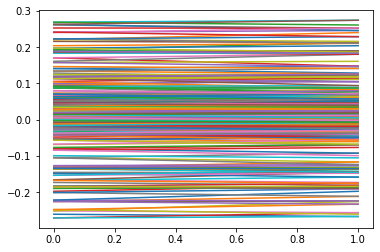

NameError: name 'linestrings_to_polygon' is not defined

In [124]:
slice_mesh_plane_bidirectional(mesh, point, normal)